In [1]:
import pandas as pd
import os
from divexplorer.FP_DivergenceExplorer import FP_DivergenceExplorer




# reproduce DivExplorer


In [2]:


inputDir=os.path.join(".", "datasets")


df= pd.read_csv(os.path.join(inputDir, "compas_discretized.csv"))
class_map={'N': 0, 'P': 1}
df.head()



,age,charge,race,sex,#prior,stay,class,predicted
0,>45,F,Other,Male,0,<week,0,0
1,25-45,F,Afr-Am,Male,0,1w-3M,1,0
2,<25,F,Afr-Am,Male,>3,<week,1,0
3,25-45,M,Other,Male,0,<week,0,0
4,25-45,F,Cauc,Male,>3,<week,1,0


In [3]:

len(df)


6172

In [42]:

import time

time1 = time.time()
min_sup=0.01 # 61.72 size threshold
# Input: a discretized dataframe with the true class and the predicted class.
# We specify their column names in the dataframe
# The class_map is a dictionary to specify the positive and the negative class (e.g. {"P":1, "N":0})
fp_diver=FP_DivergenceExplorer(df,"class", "predicted", class_map=class_map)
#Extract frequent patterns (FP) and compute divergence
##min_support: minimum support threshold
##metrics: metrics=["d_fpr", "d_fnr"]
# (default metric of interest: False Positive Rate (FPR) d_fpr, False Negative Rate (FNR) d_fnr, Accuracy divergence)
FP_fm=fp_diver.getFrequentPatternDivergence(min_support=min_sup, metrics=["d_fpr"])
time2 = time.time()
print("running time = {}s".format(time2 - time1))

running time = 1.1769459247589111s


In [43]:
print(f"Number of frequent patterns: {len(FP_fm)}")

Number of frequent patterns: 969


In [44]:
FP_fm.head()

,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
0,1.000000,(),3066,297,1962,847,0,6172.0,0.088314,0.000000,0.000000
1,0.809624,(sex=Male),2357,244,1647,749,1,4997.0,0.093810,0.005496,0.738697
2,0.772683,(stay=<week),2589,201,1487,492,1,4769.0,0.072043,-0.016271,2.339352
3,0.643227,(charge=F),1772,214,1307,677,1,3970.0,0.107754,0.019440,2.301183
4,0.614226,"(stay=<week, sex=Male)",1959,162,1236,434,2,3791.0,0.076379,-0.011935,1.555571


In [45]:

FP_fm_unfair = FP_fm[FP_fm["d_fpr"] > 0.1]
len(FP_fm_unfair)


196

In [46]:
FP_fm_unfair[:10]

,support,itemsets,tn,fp,fn,tp,length,support_count,fpr,d_fpr,t_value_fp
28,0.293422,(#prior=>3),470,132,670,539,1,1811.0,0.219269,0.130955,7.503321
35,0.256643,"(sex=Male, #prior=>3)",401,115,588,480,2,1584.0,0.222868,0.134554,7.146700
43,0.219540,"(#prior=>3, charge=F)",331,97,488,439,2,1355.0,0.226636,0.138322,6.702442
49,0.207226,"(#prior=>3, age=25-45)",297,100,469,413,2,1279.0,0.251889,0.163575,7.384973
55,0.196695,"(race=Afr-Am, #prior=>3)",283,100,403,428,2,1214.0,0.261097,0.172783,7.582039
56,0.194426,"(stay=<week, #prior=>3)",349,82,457,312,2,1200.0,0.190255,0.101941,5.283437
58,0.190376,"(sex=Male, #prior=>3, charge=F)",277,83,423,392,3,1175.0,0.230556,0.142242,6.323414
62,0.180655,"(sex=Male, #prior=>3, age=25-45)",254,86,405,370,3,1115.0,0.252941,0.164627,6.903692
64,0.178386,"(sex=Male, age=<25)",357,83,414,247,2,1101.0,0.188636,0.100322,5.265747
67,0.175308,"(sex=Male, race=Afr-Am, #prior=>3)",239,87,369,387,3,1082.0,0.266871,0.178557,7.214382


## use our algorithm on this dataset

In [6]:

inputDir=os.path.join(".", "datasets")


df= pd.read_csv(os.path.join(inputDir, "compas_discretized.csv"))
print(len(df))
df[:5]

6172


,age,charge,race,sex,#prior,stay,class,predicted
0,>45,F,Other,Male,0,<week,0,0
1,25-45,F,Afr-Am,Male,0,1w-3M,1,0
2,<25,F,Afr-Am,Male,>3,<week,1,0
3,25-45,M,Other,Male,0,<week,0,0
4,25-45,F,Cauc,Male,>3,<week,1,0


In [7]:

TP = df[(df['class'] == 1) & (df['predicted'] == 1)]
FP = df[(df['class'] == 0) & (df['predicted'] == 1)]
TN = df[(df['class'] == 0) & (df['predicted'] == 0)]
FN = df[(df['class'] == 1) & (df['predicted'] == 0)]

print(len(TP) + len(FP) + len(TN) + len(FN))

selected_attributes = ['age', 'charge', 'race', 'sex', '#prior', 'stay']
df = df[selected_attributes]
TP = TP[selected_attributes]
TN = TN[selected_attributes]
FP = FP[selected_attributes]
FN = FN[selected_attributes]

6172


In [8]:
%reload_ext autoreload

%autoreload 2

from Algorithms import NewAlgGeneral_StatisticalSignificant_0_20220125 as newalg

thc = 61.72
time_limit = 5 * 60
fairness_definition = 1  # FPR = FP/(FP+TN) False_positive_error_rate_balance, but for those treated too well
delta_thf = 0.1
pattern_with_low_fairness1, sizes_of_patterns, fairness_values_of_patterns, t_values_of_patterns,\
num_patterns, t1_ = newalg.GraphTraverse(df,
                                         TP, TN, FP, FN, delta_thf,
                                         thc, time_limit, fairness_definition)


print("newalg, time = {} s, num_calculation = {}\n".format(t1_, num_patterns))
print("num of patterns detected = {}".format(len(pattern_with_low_fairness1)))
for i in range(len(pattern_with_low_fairness1)):
    print("{} {} {} {}\n".format(str(pattern_with_low_fairness1[i]),
                              sizes_of_patterns[i], fairness_values_of_patterns[i],
                                 t_values_of_patterns[i]))



False_positive_error_rate_balance, original_thf = 0.08831400535236396, Thf = 0.18831400535236398
newalg, time = 0.06547927856445312 s, num_calculation = 0

num of patterns detected = 0


## whether FP_fm_unfair are descendents of pattern_with_low_fairness1 (yes)

In [57]:

def P1DominatedByP2(P1, P2):
    length = len(P1)
    for i in range(length):
        if P1[i] == -1:
            if P2[i] != -1:
                return False
        if P1[i] != -1:
            if P2[i] != P1[i] and P2[i] != -1:
                return False
    return True

# whether a pattern P is dominated by MUP M
# except from P itself
def PDominatedByM(P, M):
    for m in M:
        if PatternEqual(m, P):
            return True, m
        if P1DominatedByP2(P, m):
            return True, m
    return False, None



def PatternEqual(m, P):
    length = len(m)
    if len(P) != length:
        return False
    for i in range(length):
        if m[i] != P[i]:
            return False
    return True


for p in FP_fm_unfair:
    if PDominatedByM(p, pattern_with_low_fairness1):
        continue
    else:
        raise Exception("noooo")







# reproduce ProPublica by DivExplorer and our algorithm

## reproduce ProPublica by DivExplorer

In [11]:


original_data_file = r"../../../../InputData/COMPAS_ProPublica/compas-analysis-master/cox-parsed/cox-parsed_7214rows_cat.csv"
TP_data_file = r"../../../../InputData/COMPAS_ProPublica/compas-analysis-master/cox-parsed/cox-parsed-TP-cat.csv"
FP_data_file = r"../../../../InputData/COMPAS_ProPublica/compas-analysis-master/cox-parsed/cox-parsed-FP-cat.csv"
TN_data_file = r"../../../../InputData/COMPAS_ProPublica/compas-analysis-master/cox-parsed/cox-parsed-TN-cat.csv"
FN_data_file = r"../../../../InputData/COMPAS_ProPublica/compas-analysis-master/cox-parsed/cox-parsed-FN-cat.csv"




In [12]:

data_file = r"../../../../InputData/COMPAS_ProPublica/compas-analysis-master/cox-parsed/cox-parsed_7214rows_with_labels.csv"

df= pd.read_csv(data_file)
class_map={'N': 0, 'P': 1}
print(len(df))
df.head()


7214


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,predicted,ground_truth
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,0,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,Medium,2013-01-13,NaN,NaN,1,0,1174,0,1,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,2013-03-26,NaN,NaN,2,0,1102,0,0,0


In [13]:

ignore_columns = df.columns.to_list()
ignore_columns.remove("sex")
ignore_columns.remove("race")
ignore_columns.remove("age_cat")
ignore_columns.remove("predicted")
ignore_columns.remove("ground_truth")


In [15]:

# def __init__(
#     self,
#     X_discrete,
#     true_class_name,
#     predicted_class_name=None,
#     class_map={},
#     ignore_cols=[],
#     log_loss_values=None,
#     clf=None,
#     dataset_name="",
#     type_cl="",
# ):


min_sup=0.01 # 61.72 size threshold
# Input: a discretized dataframe with the true class and the predicted class.
# We specify their column names in the dataframe
# The class_map is a dictionary to specify the positive and the negative class (e.g. {"P":1, "N":0})

import time
time1 = time.time()
fp_diver=FP_DivergenceExplorer(df,"ground_truth", "predicted", class_map=class_map, ignore_cols=ignore_columns)
#Extract frequent patterns (FP) and compute divergence
##min_support: minimum support threshold
##metrics: metrics=["d_fpr", "d_fnr"]
# (default metric of interest: False Positive Rate (FPR) d_fpr, False Negative Rate (FNR) d_fnr, Accuracy divergence)
FP_fm=fp_diver.getFrequentPatternDivergence(min_support=min_sup, metrics=["d_fnr"])
FP_fm_unfair = FP_fm[FP_fm["d_fnr"] > 0.1]
time2 = time.time()
print(f"Number of frequent patterns: {len(FP_fm)}")
print("number of unfair patterns = {}".format(len(FP_fm_unfair)))
print("running time = {}".format(time2 - time1))
print("{}".format(FP_fm_unfair["itemsets"]))


Number of frequent patterns: 51
number of unfair patterns = 22
running time = 0.12210392951965332
6                                      (race=Caucasian)
8                            (sex=Male, race=Caucasian)
10                            (age_cat=Greater than 45)
14                  (sex=Male, age_cat=Greater than 45)
16          (sex=Male, age_cat=25 - 45, race=Caucasian)
19            (race=Caucasian, age_cat=Greater than 45)
22                                      (race=Hispanic)
24    (sex=Male, race=Caucasian, age_cat=Greater tha...
26                            (sex=Male, race=Hispanic)
30                                         (race=Other)
31                     (age_cat=25 - 45, race=Hispanic)
32                               (race=Other, sex=Male)
34           (sex=Male, age_cat=25 - 45, race=Hispanic)
36                (sex=Female, age_cat=Greater than 45)
38                        (race=Other, age_cat=25 - 45)
39              (race=Other, sex=Male, age_cat=25 - 45)
40    

In [16]:

FP_fm_unfair


,support,itemsets,tn,fp,fn,tp,length,support_count,fnr,d_fnr,t_value_fn
6,0.340172,(race=Caucasian),1139,349,461,505,1,2454.0,0.477226,0.103187,5.683547
8,0.261575,"(sex=Male, race=Caucasian)",882,238,375,392,2,1887.0,0.488918,0.114879,5.766989
10,0.218464,(age_cat=Greater than 45),897,181,285,213,1,1576.0,0.572289,0.198250,8.357542
14,0.176878,"(sex=Male, age_cat=Greater than 45)",703,146,238,189,2,1276.0,0.557377,0.183338,7.201065
16,0.139035,"(sex=Male, age_cat=25 - 45, race=Caucasian)",420,148,212,223,3,1003.0,0.487356,0.113318,4.470216
19,0.104242,"(race=Caucasian, age_cat=Greater than 45)",491,52,144,65,2,752.0,0.688995,0.314956,9.501053
22,0.088301,(race=Hispanic),318,87,129,103,1,637.0,0.556034,0.181996,5.415124
24,0.080538,"(sex=Male, race=Caucasian, age_cat=Greater tha...",378,35,113,55,3,581.0,0.672619,0.298580,8.028109
26,0.074023,"(sex=Male, race=Hispanic)",255,80,105,94,2,534.0,0.527638,0.153599,4.240734
30,0.052259,(race=Other),208,36,90,43,1,377.0,0.676692,0.302653,7.302187


[0.12497566276357142, 0.13765877532644588, 0.11746710578385122, 0.13960293428499337, 0.21786107964840185, 0.1907934104754695, 0.2753934900616215, 0.26297386160328906, 0.1639448821194035, 0.29365055333261236, 0.3109162983402929, 0.151917532255329, 0.20591946089563762, 0.3765076961897552, 0.12888864857070764] [8.999310075609277, 9.005013822693135, 6.996435622259253, 7.4605235327035, 10.53402246516901, 8.042809168197255, 10.246106485918853, 8.476220681466526, 4.5619878918308645, 7.85448747558272, 6.185974519510599, 2.42739348207005, 2.995737232499526, 6.318158014347071, 1.755603216098227]


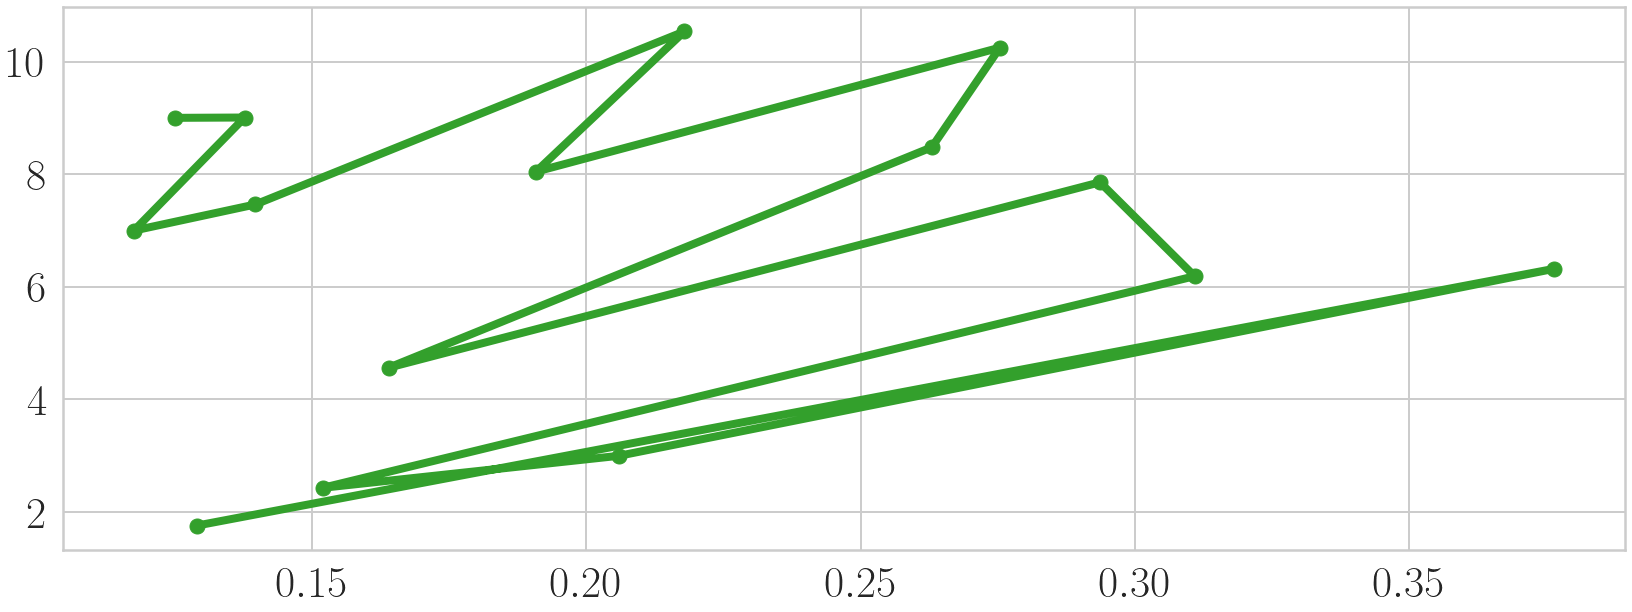

In [29]:
# when d_fpr grows, does t-value grow??

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
sns.set_palette("Paired")
sns.set_context("poster", font_scale=2)
sns.set_style("whitegrid")
line_style = ['o-', 's-', 'p-', '^-', 'o:', 's:', 'p:', '^:']
color = ['C3', 'C5', sns.xkcd_rgb["amber"], 'C9', 'C3', 'C5', sns.xkcd_rgb["amber"], 'C9']
# plt_title = ["BlueNile", "COMPAS", "Credit Card"]
label = ["Adult (acc)", "COMPAS (acc)", "Credit card (acc)", "Medical (acc)",
         "Adult (FPR)", "COMPAS (FPR)", "Credit card (FPR)", "Medical (FPR)"]
line_width = 8
marker_size = 15
f_size = (28, 10)
def thousands_formatter(x, pos):
    return int(x/1000)

x_list = FP_fm_unfair['d_fpr'].to_list()
y_list = FP_fm_unfair['t_value_fp'].to_list()

print(x_list, y_list)

fig, ax = plt.subplots(1, 1, figsize=f_size)
plt.plot(x_list, y_list, line_style[0], color=color[0], label=label[0], linewidth=line_width,
      markersize=marker_size)
# plt.xlabel('d_fpr')
# plt.ylabel('t_value')
# # plt.legend(bbox_to_anchor=(0.95, 0.9), loc='center', fontsize='x-small', ncol=1)
# # plt.legend(bbox_to_anchor=(1.01, 1.01), loc='upper right', fontsize='x-small', ncol=2)
# plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
# plt.grid(True)
# # fig.tight_layout()
# # plt.savefig("thc_time.png",

# #             bbox_inches='tight')
# plt.show()
# plt.close()




## reproduce ProPublica by our algorithm (FPR)

In [1]:
%reload_ext autoreload

%autoreload 2

import pandas as pd
from Algorithms import NewAlgGeneral_StatisticalSignificant_0_20220125 as newalg

"""
cox['sex'].replace(to_replace=['Male', 'Female'], value=[0, 1], inplace=True)


cox['age_cat'].replace(to_replace=['Less than 25', '25 - 45', 'Greater than 45'], value=[0, 1, 2], inplace=True)

cox['race'].replace(to_replace=['African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other'], value=[0, 1, 2, 3, 4, 5], inplace=True)


"""

selected_attributes = ["sex", "age_cat", "race"]

original_data_file = r"../../../../InputData/COMPAS_ProPublica/compas-analysis-master/cox-parsed/cox-parsed_7214rows_cat.csv"
TP_data_file = r"../../../../InputData/COMPAS_ProPublica/compas-analysis-master/cox-parsed/cox-parsed-TP-cat.csv"
FP_data_file = r"../../../../InputData/COMPAS_ProPublica/compas-analysis-master/cox-parsed/cox-parsed-FP-cat.csv"
TN_data_file = r"../../../../InputData/COMPAS_ProPublica/compas-analysis-master/cox-parsed/cox-parsed-TN-cat.csv"
FN_data_file = r"../../../../InputData/COMPAS_ProPublica/compas-analysis-master/cox-parsed/cox-parsed-FN-cat.csv"

output_path = r'../../../../OutputData/CaseStudy/ProPublica/fp_greater_than_trying.txt'
output_file = open(output_path, "w")

output_file.write("selected_attributes: {}\n".format(selected_attributes))


def read_with_att(original_data_file, selected_attributes):
    original_data = pd.read_csv(original_data_file)
    less_attribute_data = original_data[selected_attributes]
    return less_attribute_data


less_attribute_data = read_with_att(original_data_file, selected_attributes)
TP = read_with_att(TP_data_file, selected_attributes)
FP = read_with_att(FP_data_file, selected_attributes)
TN = read_with_att(TN_data_file, selected_attributes)
FN = read_with_att(FN_data_file, selected_attributes)


# thc = 3696 this is the max thc to find black [-1, -1, 0]
thc = 20
time_limit = 5 * 60
# fairness_definition = 1 # FPR = FP/(FP+TN) False_positive_error_rate_balance

fairness_definition = 1  # FPR = FP/(FP+TN) False_positive_error_rate_balance, but for those treated too well
delta_thf = 0.1

output_file.write("fairness_definition = {}, thc = {}, delta_thf = {}\n".format(fairness_definition, thc, delta_thf))


pattern_with_low_fairness1, sizes_of_patterns, fairness_values_of_patterns, t_values_of_patterns, p_value_of_patterns, \
num_patterns, t1_ = newalg.GraphTraverse(less_attribute_data,
                                         TP, TN, FP, FN, delta_thf,
                                         thc, time_limit, fairness_definition)

print("newalg, time = {} s, num_calculation = {}\n".format(t1_, num_patterns))
print("num of patterns detected = {}".format(len(pattern_with_low_fairness1)))
for i in range(len(pattern_with_low_fairness1)):
    print("{} {} {} {} {}\n".format(str(pattern_with_low_fairness1[i]),
                                          sizes_of_patterns[i], fairness_values_of_patterns[i],
                                          t_values_of_patterns[i],
                                 p_value_of_patterns[i]))


output_file.write("newalg, time = {} s, num_calculation = {}\n".format(t1_, num_patterns))
output_file.write("num of patterns detected = {}\n".format(len(pattern_with_low_fairness1)))
for i in range(len(pattern_with_low_fairness1)):
    output_file.write("{} {} {} {} {}\n".format(str(pattern_with_low_fairness1[i]),
                                          sizes_of_patterns[i], fairness_values_of_patterns[i],
                                          t_values_of_patterns[i],
                                             p_value_of_patterns[i]))


False_positive_error_rate_balance, original_thf = 0.32349230381024474, Thf = 0.4234923038102447
p_value: 2.9751009799373e-19 p_2: 0.0 p_3: 2.9751009799373e-19

 Welch's t-test= 8.9993 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 6171.4435
p_value: 3.2729941888880294e-12 p_2: 3.2729374765949615e-12 p_3: 3.2729941888880294e-12

 Welch's t-test= 6.9964 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 2795.5880
p_value: 3.503828058118625e-25 p_2: 0.0 p_3: 3.503828058118625e-25

 Welch's t-test= 10.5340 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 1705.9134
p_value: 7.953445913587729e-14 p_2: 7.949196856316121e-14 p_3: 7.953445913587729e-14

 Welch's t-test= 7.8545 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 288.7345
p_value: 3.1298069051729424e-19 p_2: 0.0 p_3: 3.1298069051729424e-19

 Welch's t-test= 9.0050 
 p-value = 0.0000 
 Welch-Satterthwaite Degrees of Freedom= 4467.2980
p_value: 1.252310447828391e-13 p_2: 1.25233157177717




# use data from ProPublica but do FNR

## our algorithm

In [5]:
import pandas as pd
from Algorithms import NewAlgGeneral_StatisticalSignificant_0_20220125 as newalg

"""
cox['sex'].replace(to_replace=['Male', 'Female'], value=[0, 1], inplace=True)


cox['age_cat'].replace(to_replace=['Less than 25', '25 - 45', 'Greater than 45'], value=[0, 1, 2], inplace=True)

cox['race'].replace(to_replace=['African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other'], value=[0, 1, 2, 3, 4, 5], inplace=True)


"""

selected_attributes = ["sex", "age_cat", "race"]

original_data_file = r"../../../../InputData/COMPAS_ProPublica/compas-analysis-master/cox-parsed/cox-parsed_7214rows_cat.csv"
TP_data_file = r"../../../../InputData/COMPAS_ProPublica/compas-analysis-master/cox-parsed/cox-parsed-TP-cat.csv"
FP_data_file = r"../../../../InputData/COMPAS_ProPublica/compas-analysis-master/cox-parsed/cox-parsed-FP-cat.csv"
TN_data_file = r"../../../../InputData/COMPAS_ProPublica/compas-analysis-master/cox-parsed/cox-parsed-TN-cat.csv"
FN_data_file = r"../../../../InputData/COMPAS_ProPublica/compas-analysis-master/cox-parsed/cox-parsed-FN-cat.csv"

output_path = r'../../../../OutputData/CaseStudy/ProPublica/fp_greater_than_trying.txt'
output_file = open(output_path, "w")

output_file.write("selected_attributes: {}\n".format(selected_attributes))



def read_with_att(original_data_file, selected_attributes):
    original_data = pd.read_csv(original_data_file)
    less_attribute_data = original_data[selected_attributes]
    return less_attribute_data


less_attribute_data = read_with_att(original_data_file, selected_attributes)
TP = read_with_att(TP_data_file, selected_attributes)
FP = read_with_att(FP_data_file, selected_attributes)
TN = read_with_att(TN_data_file, selected_attributes)
FN = read_with_att(FN_data_file, selected_attributes)




thc = 20
time_limit = 5 * 60
# fairness_definition = 1 # FPR = FP/(FP+TN) False_positive_error_rate_balance

fairness_definition = 2 # FNR = FP/(FP+TN) False_positive_error_rate_balance, but for those treated too well
delta_thf = 0.1



output_file.write("fairness_definition = {}, thc = {}, delta_thf = {}\n".format(fairness_definition, thc, delta_thf))

# print("less_attribute_data")
# print(less_attribute_data)

pattern_with_low_fairness1, sizes_of_patterns, fairness_values_of_patterns, t_values_of_patterns, p_value_of_patterns, \
num_patterns, t1_ = newalg.GraphTraverse(less_attribute_data,
                                         TP, TN, FP, FN, delta_thf,
                                         thc, time_limit, fairness_definition)

print("newalg, time = {} s, num_calculation = {}\n".format(t1_, num_patterns))
print("num of patterns detected = {}".format(len(pattern_with_low_fairness1)))
for i in range(len(pattern_with_low_fairness1)):
    print("{} {} {} {} {}\n".format(str(pattern_with_low_fairness1[i]),
                                          sizes_of_patterns[i], fairness_values_of_patterns[i],
                                          t_values_of_patterns[i],
                                 p_value_of_patterns[i]))


output_file.write("newalg, time = {} s, num_calculation = {}\n".format(t1_, num_patterns))
output_file.write("num of patterns detected = {}\n".format(len(pattern_with_low_fairness1)))
for i in range(len(pattern_with_low_fairness1)):
    output_file.write("{} {} {} {} {}\n".format(str(pattern_with_low_fairness1[i]),
                                          sizes_of_patterns[i], fairness_values_of_patterns[i],
                                          t_values_of_patterns[i],
                                             p_value_of_patterns[i]))


False_negative_error_rate_balance, original_thf = 0.3740387573054445, Thf = 0.47403875730544454
newalg, time = 0.06280303001403809 s, num_calculation = 65

num of patterns detected = 4
[-2, -2, 5] 377 0.6766917293233082 7.302187170915806 1.6749871823338957e-12

[-2, -2, 3] 637 0.5560344827586207 5.415123898793821 8.61551962297769e-08

[-2, -2, 2] 2454 0.4772256728778468 5.68354676378254 1.4278291248885885e-08

[-2, 2, -2] 1576 0.572289156626506 8.357541614746069 1.261803361406437e-16



## DivExplorer

In [25]:

# def __init__(
#     self,
#     X_discrete,
#     true_class_name,
#     predicted_class_name=None,
#     class_map={},
#     ignore_cols=[],
#     log_loss_values=None,
#     clf=None,
#     dataset_name="",
#     type_cl="",
# ):


min_sup=0.01 # 61.72 size threshold
# Input: a discretized dataframe with the true class and the predicted class.
# We specify their column names in the dataframe
# The class_map is a dictionary to specify the positive and the negative class (e.g. {"P":1, "N":0})

import time
time1 = time.time()
fp_diver=FP_DivergenceExplorer(df,"ground_truth", "predicted", class_map=class_map, ignore_cols=ignore_columns)
#Extract frequent patterns (FP) and compute divergence
##min_support: minimum support threshold
##metrics: metrics=["d_fpr", "d_fnr"]
# (default metric of interest: False Positive Rate (FPR) d_fpr, False Negative Rate (FNR) d_fnr, Accuracy divergence)
FP_fm=fp_diver.getFrequentPatternDivergence(min_support=min_sup, metrics=["d_accuracy"])
FP_fm_unfair = FP_fm[FP_fm["d_accuracy"] > -0.1]
time2 = time.time()
print(f"Number of frequent patterns: {len(FP_fm)}")
print("number of unfair patterns = {}".format(len(FP_fm_unfair)))
print("running time = {}".format(time2 - time1))
print("{}".format(FP_fm_unfair["itemsets"]))

Number of frequent patterns: 51
number of unfair patterns = 49
running time = 0.11466479301452637
0                                                    ()
1                                            (sex=Male)
2                                     (age_cat=25 - 45)
3                               (race=African-American)
4                           (age_cat=25 - 45, sex=Male)
5                     (sex=Male, race=African-American)
6                                      (race=Caucasian)
7              (age_cat=25 - 45, race=African-American)
8                            (sex=Male, race=Caucasian)
9     (age_cat=25 - 45, sex=Male, race=African-Ameri...
10                            (age_cat=Greater than 45)
11                               (age_cat=Less than 25)
12                                         (sex=Female)
13                    (age_cat=25 - 45, race=Caucasian)
14                  (sex=Male, age_cat=Greater than 45)
15                     (sex=Male, age_cat=Less than 25)
16    

# Medical dataset

## DivExplorer

In [38]:

data_file = r"../../../../InputData/MedicalDataset/train/train_41att_with_labels.csv"
df= pd.read_csv(data_file)
TP = df[(df['ground_truth'] == 1) & (df['predicted'] == 1)]
TN = df[(df['ground_truth'] == 0) & (df['predicted'] == 0)]
FP = df[(df['ground_truth'] == 0) & (df['predicted'] == 1)]
FN = df[(df['ground_truth'] == 1) & (df['predicted'] == 0)]
print(len(df), len(TP), len(TN), len(FP), len(FN))



7915 942 5576 1014 383


In [ ]:

data_file = r"../../../../InputData/MedicalDataset/train/train_41att_with_labels.csv"

df= pd.read_csv(data_file)
class_map={'N': 0, 'P': 1}
print(len(df))
df.head()


In [36]:

ignore_columns = df.columns.to_list()
# 13 attributes
selected_attributes = ["REGION", "SEX", "MARRY", "RACE", "FTSTU", "ACTDTY", "HONRDC", "RTHLTH", "MNHLTH", "HIBPDX", "CHDDX", "ANGIDX", "MIDX"]
ignore_columns.remove("predicted")
ignore_columns.remove("ground_truth")

for att in selected_attributes[:10]:
    ignore_columns.remove(att)


min_sup=0.014 # 110 size threshold
# Input: a discretized dataframe with the true class and the predicted class.
# We specify their column names in the dataframe
# The class_map is a dictionary to specify the positive and the negative class (e.g. {"P":1, "N":0})

import time
time1 = time.time()
fp_diver=FP_DivergenceExplorer(df,"ground_truth", "predicted", class_map=class_map, ignore_cols=ignore_columns)
#Extract frequent patterns (FP) and compute divergence
##min_support: minimum support threshold
##metrics: metrics=["d_fpr", "d_fnr"]
# (default metric of interest: False Positive Rate (FPR) d_fpr, False Negative Rate (FNR) d_fnr, Accuracy divergence)
FP_fm=fp_diver.getFrequentPatternDivergence(min_support=min_sup, metrics=["d_accuracy"])
FP_fm_unfair = FP_fm[FP_fm["d_accuracy"] > 0.1]
time2 = time.time()
print(f"Number of frequent patterns: {len(FP_fm)}")
print("number of unfair patterns = {}".format(len(FP_fm_unfair)))
print("running time = {}".format(time2 - time1))
print("{}".format(FP_fm_unfair["itemsets"]))



ValueError: list.remove(x): x not in list